In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/AbnerHqC/GaitSet.git

Cloning into 'GaitSet'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 106 (delta 29), reused 22 (delta 22), pack-reused 62 (from 1)
Receiving objects: 100% (106/106), 54.42 MiB | 14.92 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
!unzip "/content/drive/MyDrive/preprocessed.zip" -d /content/GaitSet/

Streaming output truncated to the last 5000 lines.
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-062.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-063.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-064.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-065.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-066.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-067.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-068.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-069.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-070.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-071.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/124-cl-02-162-072.png  
 extracting: /content/GaitSet/preprocessed/124/cl-02/162/1

In [ ]:
cd GaitSet

/content/GaitSet


In [ ]:
from model.network.gaitset import SetNet
import torch.optim as optim
import torch.nn as nn
import torch
import os.path as osp
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

In [ ]:
encoder = SetNet(256)
encoder = nn.DataParallel(encoder)
encoder.cuda()

model_name = 'GaitSet'
encoder.load_state_dict(torch.load('/content/GaitSet/work/GaitSet_CASIA-B_73_False_256_0.2_128_full_30-108100-encoder.ptm'))

<All keys matched successfully>

In [ ]:
encoder.eval()

from model.initialization import initialize_data
from config import conf

train_source, test_source = initialize_data(conf, train = False, test = True)

Initializing data source...
Loading training data...
Data initialization complete.


In [ ]:
from copy import deepcopy
import numpy as np

# train_source, test_source = initialize_data(conf, train = False, test = False)
data_config = conf['data']
model_config = conf['model']
model_param = deepcopy(model_config)
model_param['train_source'] = None
model_param['test_source'] = test_source
model_param['train_pid_num'] = data_config['pid_num']
batch_size = int(np.prod(model_config['batch_size']))
model_param['save_name'] = '_'.join(map(str,[
    model_config['model_name'],
    data_config['dataset'],
    data_config['pid_num'],
    data_config['pid_shuffle'],
    model_config['hidden_dim'],
    model_config['margin'],
    batch_size,
    model_config['hard_or_full_trip'],
    model_config['frame_num'],
]))
restore_iter = 80000

In [ ]:
import torch.utils.data as tordata
from model.model import Model

model = Model(**model_param)
data_loader = tordata.DataLoader(
            dataset=test_source,
            batch_size=1,
            sampler=tordata.sampler.SequentialSampler(test_source),
            collate_fn=model.collate_fn,
            num_workers=2)

In [ ]:
data_loader

In [ ]:
feature_list = list()
view_list = list()
seq_type_list = list()
label_list = list()

In [ ]:
for i, data in enumerate(data_loader):
    seq, view, seq_type, label, batch_frame = data

    seq[0] = model.np2var(seq[0])
    batch_frame = model.np2var(batch_frame)

    feature, _ = encoder(*seq, batch_frame)
    feature_list.append(feature.view(1, -1).data.cpu().numpy())
    view_list += view
    seq_type_list += seq_type
    label_list += label

In [ ]:
data = np.concatenate(feature_list, 0), view_list, seq_type_list, label_list
feature, view, seq_type, label = data
label = np.array(label)
view_list = list(set(view))
view_list.sort()
view_num = len(view_list)
sample_num = len(feature)

In [ ]:
feature.shape

(5485, 15872)

In [ ]:
# Lưu đặc trưng theo các lớp nm, bg, cl để dự đoán
class_features = {'nm': [], 'bg': [], 'cl': []}

for i, seq in enumerate(data[2]):
  if 'nm' in seq:
      class_features['nm'].append(data[0][i])
  elif 'bg' in seq:
      class_features['bg'].append(data[0][i])
  elif 'cl' in seq:
      class_features['cl'].append(data[0][i])

for cls in class_features:
    class_features[cls] = torch.tensor(np.array(class_features[cls]))

for cls, feats in class_features.items():
    print(f"Class {cls}: {feats.shape}")

Class nm: torch.Size([3287, 15872])
Class bg: torch.Size([1098, 15872])
Class cl: torch.Size([1100, 15872])


In [ ]:
cd /content

/content


In [ ]:
torch.save(class_features, 'gaitset_features.pt')
print("Features saved successfully!")

Features saved successfully!


In [ ]:
def plot_feature(type, same_label=True):
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, 50))

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    pca = PCA(n_components=2)
    reducer = umap.UMAP(n_components=2)

    if type == 'umap':
        clusters = reducer.fit_transform(feature)
    elif type == 'tsne':
        clusters = tsne.fit_transform(feature)
    elif type == 'pca':
        clusters = pca.fit_transform(feature)

    # Create one figure for all plots
    plt.figure(figsize=(8, 8))

    for i in range(feature.shape[0]):
        x = clusters[i, 0]
        y = clusters[i, 1]

        if not same_label:
            plt.scatter(x, y, color=colors[i], s=10)
        else:
            plt.scatter(x, y, color=colors[int(label[i]) - 117], s=5)
    plt.grid(True)
    # plt.legend()
    plt.show()

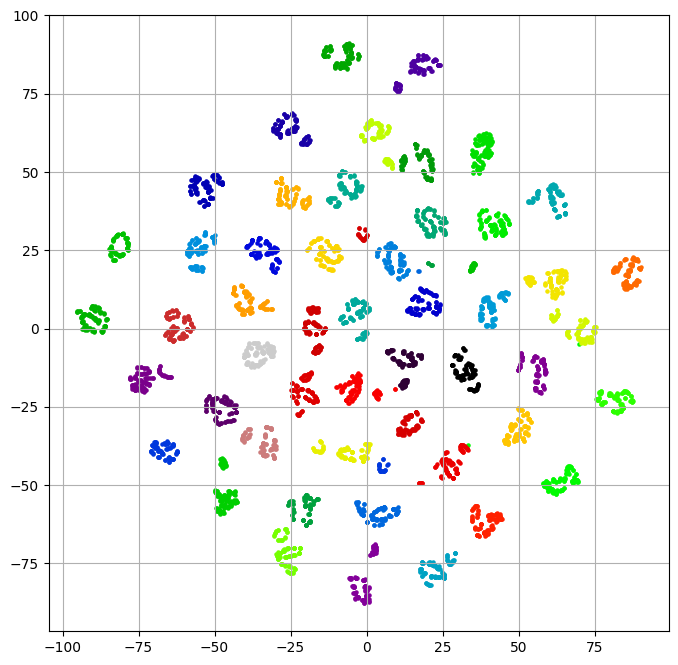

In [ ]:
plot_feature('tsne', same_label=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


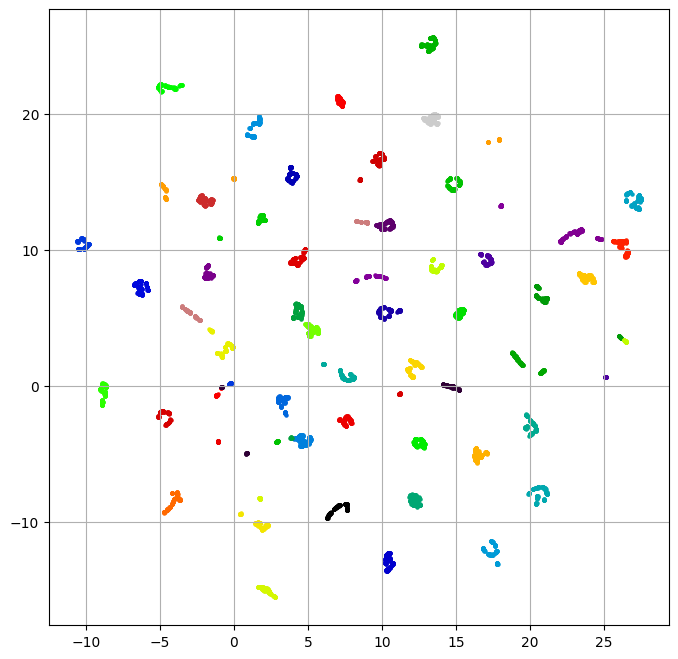

In [ ]:
plot_feature('umap', same_label=True)

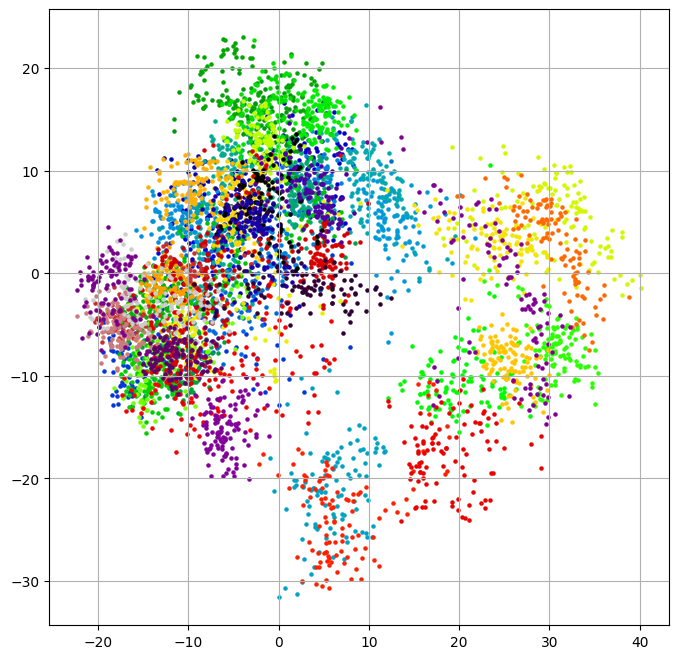

In [ ]:
plot_feature('pca', same_label=True)

In [ ]:
probe_seq_dict =  [['nm-05', 'nm-06'], ['bg-01', 'bg-02'], ['cl-01', 'cl-02']]
gallery_seq_dict = [['nm-01', 'nm-02', 'nm-03', 'nm-04']]

In [ ]:
def euclid_dist(a, b):
    a2 = np.sum(a**2, axis=1, keepdims=True)
    b2 = np.sum(b**2, axis=1, keepdims=True)
    dist = a2 + b2.T - 2 * a @ b.T
    dist = np.sqrt(np.maximum(0, dist))
    return dist


In [ ]:
acc = np.zeros([len(probe_seq_dict), view_num, view_num])
for (p, probe_seq) in enumerate(probe_seq_dict):
    for gallery_seq in gallery_seq_dict:
        for (v1, probe_view) in enumerate(view_list):
            for (v2, gallery_view) in enumerate(view_list):
                gseq_mask = np.isin(view, gallery_view) & np.isin(seq_type, gallery_seq)
                pseq_mask = np.isin(view, probe_view) & np.isin(seq_type, probe_seq)

                gseq = feature[gseq_mask]  # 200, (62 x 256)
                pseq = feature[pseq_mask]   # 100, (62 x 256)

                dist = euclid_dist(pseq, gseq) # 100, 200
                idx = np.argmin(dist, axis=1)  # 100

                gseq_label = label[gseq_mask]  # 200,
                pseq_label = label[pseq_mask]  # 100,
                # print(idx)
                # print(np.sum(gseq_label[idx] == pseq_label) * 100 / 16)
                acc[p, v1, v2] = np.sum(gseq_label[idx] == pseq_label) * 100 / 100

    #             break
    #         break
    #     break
    # break


In [ ]:
print(acc)

[[[100. 100.  96.  90.  82.  77.  87.  93.  93.  99. 100.]
  [100. 100. 100. 100.  95.  91.  91.  98.  97.  99. 100.]
  [ 99. 100. 100. 100. 100.  97.  98. 100. 100. 100.  91.]
  [ 91. 100. 100. 100. 100. 100. 100. 100.  99.  97.  88.]
  [ 80.  98. 100. 100. 100. 100.  99.  99.  99.  91.  75.]
  [ 70.  93.  96.  99. 100. 100.  99.  98.  96.  91.  74.]
  [ 76.  91.  98. 100. 100. 100. 100. 100.  99.  93.  82.]
  [ 84.  97. 100. 100. 100. 100. 100. 100. 100.  99.  94.]
  [ 90.  99. 100.  98.  98.  96.  97. 100. 100. 100.  96.]
  [ 98. 100.  99.  96.  94.  88.  90.  97. 100. 100.  99.]
  [100.  96.  91.  83.  76.  73.  80.  87.  95. 100. 100.]]

 [[100. 100.  95.  86.  76.  69.  75.  86.  87.  91.  99.]
  [ 97. 100.  99.  95.  86.  84.  88.  90.  95.  93.  88.]
  [ 92.  96.  99.  99.  97.  94.  93.  95.  93.  91.  83.]
  [ 79.  90.  98.  98.  98.  95.  96.  95.  91.  82.  75.]
  [ 70.  84.  90.  96. 100.  99.  98.  93.  89.  73.  59.]
  [ 57.  79.  86.  92.  98.  98.  96.  93.  86.  65.  

In [ ]:
np.sum(acc)/(3 * 11 * 11)

np.float64(85.05785123966942)